# Monitor segmentation

In [ ]:
import torch
import pandas as pd
from PIL import Image

In [ ]:
monitor_segmenter = torch.hub.load('ultralytics/yolov5', 'custom', '/home/sharchit/Desktop/ml/cloud-physician/yolo/yolov5/runs/train/exp5/weights/best.pt')

Using cache found in /home/sharchit/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-2 Python-3.9.13 torch-1.13.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [ ]:
def getMonitorSegment(path):
    img = Image.open(path)
    predictions = monitor_segmenter(img)
    df = predictions.pandas().xywh[0]
    df = df[df.confidence==df.confidence.max()]
    print(df)
    xcenter = df.iloc[0]['xcenter']
    ycenter = df.iloc[0]['ycenter']
    width = df.iloc[0]['width']
    height = df.iloc[0]['height']
    img = img.crop((xcenter - width / 2, ycenter - height / 2, xcenter + width / 2, ycenter + height/2))
    img = img.resize((416, 416))
    return img

# Monitor Classification

1) Using Resnet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [ ]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [ ]:
class MyResnet18(nn.Module):
    def __init__(self, model):
        super(MyResnet18, self).__init__()
        self.pretrained = model
        self.my_new_layers = nn.Sequential(nn.Linear(num_ftrs, 256),
                                           nn.ReLU(),
                                           nn.Linear(256, 4))
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.my_new_layers(x)
        return x

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
monitor_classifier = MyResnet18(model)
monitor_classifier.load_state_dict(torch.load('/home/sharchit/Desktop/ml/cloud-physician/NK-cropped.zip'))

In [ ]:
def prediction(image):
      loader = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])
      img = loader(image).float()
      img = img.unsqueeze(0) 
      return torch.argmax(model(img)).item()

In [ ]:
img = Image.open('/home/sharchit/Desktop/ml/cloud-physician/BPL-EliteView-EV10-B_Meditec-England-A/aveksha_micu_mon-121_2021_11_23_16_0_2.jpeg')
prediction(img)

2) kMeans

In [ ]:
import pickle
loaded_model = pickle.load(open("cluster_model", 'rb'))

# Output label   Image name label
      0                 1
      1                 0
      2                 2
      3                 3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil
import cv2

In [ ]:
# Function to Extract features from the images
def image_feature(imgarray):
    model = InceptionV3(weights='imagenet', include_top=False)
    features = [];
    x = imgarray
    x=np.expand_dims(x,axis=0)
    x=preprocess_input(x)
    feat=model.predict(x)
    feat=feat.flatten()
    features.append(feat)
    return features

In [ ]:
#x is the array for the bounding box of monitor
#we need x
res = cv2.resize(x, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
img_features=image_feature(res)

In [ ]:
result = loaded_model.predict((np.array(img_features[0]).reshape(-1,len(img_features[0])).astype(float)))
print(result)

# Get Digits

In [ ]:
digit_segmenter = torch.hub.load('ultralytics/yolov5', 'custom', '/home/sharchit/Desktop/ml/cloud-physician/yolo/yolov5/runs/train/common-digit-id/weights/best.pt')

Using cache found in /home/sharchit/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-2 Python-3.9.13 torch-1.13.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [ ]:
from PIL import Image, ImageOps

def remove_glare(image):
    return ImageOps.autocontrast(image, cutoff=0)

## NK

In [ ]:
import pickle

In [ ]:
xgb_NK_path = '/home/sharchit/Desktop/ml/cloud-physician/NK-xgb.pkl'
xgb_NK = pickle.load(open(xgb_NK_path, "rb"))

In [ ]:
def getDigit_BPL_A(image):
    #display(image)
    predictions = digit_segmenter(image)
    #predictions.show()
    df = predictions.pandas().xywh[0].sort_values(by = ['confidence'], ascending = False).head(6)
    digits = []
    read_digits = {
        'hr_label': None, 
        'sbp_label': None, 
        'dbp_label': None, 
        'map_label': None,
        'spo2_label': None,
        'rr_label': None
    }
    
    for i in range(df.shape[0]):
        xcenter = df.iloc[i]['xcenter']
        ycenter = df.iloc[i]['ycenter']        
        width = df.iloc[i]['width']        
        height = df.iloc[i]['height']
        
        vector = xgb_NK.predict(np.array([xcenter/416, ycenter/416, width/416, height/416]).reshape(1, 4))
        label = np.argmax(vector)
        
        digit = image.crop((xcenter - width / 2 - 15, ycenter - height / 2 - 15, xcenter + width / 2 + 15, ycenter + height/2 + 15))
        digit = remove_glare(digit)
        digits.append(digit)
        
        display(digit)
        print(label)
        print(readImage(digit))
        
        if label == 0:
            read_digits['hr_label'] = readImage(digit)
        elif label == 1:
            read_digits['sbp_label'] = readImage(digit)
        elif label == 2:
            if int(readImage(digit)) > 100:
                read_digits['dbp_label'] = str(int(readImage(digit))-100)
            else:
                read_digits['dbp_label'] = readImage(digit)
        elif label == 3:
            read_digits['map_label'] = readImage(digit)
        elif label == 4:
            read_digits['spo2_label'] = readImage(digit)
        else:
            read_digits['rr_label'] = readImage(digit)
        print('\n\n')
        
    return read_digits

      xcenter     ycenter       width      height  confidence  class     name
0  558.196838  309.159851  419.867554  377.091888    0.650683      0  Monitor


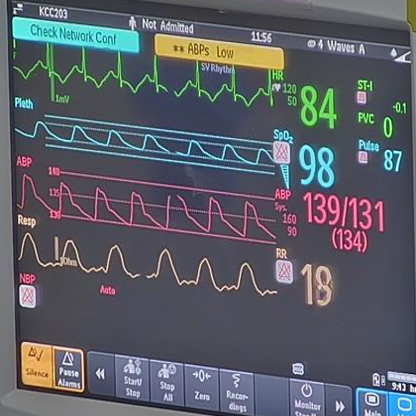

In [ ]:
getMonitorSegment('/home/sharchit/Desktop/ml/cloud-physician/images_Monitor_Segmentation/4.jpeg')

# OCR

In [ ]:
#Function, pass cropped images as input
import easyocr, numpy as np
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
def readImage(image):
    result = reader.readtext(np.array(image), allowlist="0123456789()/")
    try:
        accu = result[0][2]
        ans = ''
        for char in result[0][1]:
            if char in '0123456789':
                ans += char
    except:
        ans = 0
    return ans

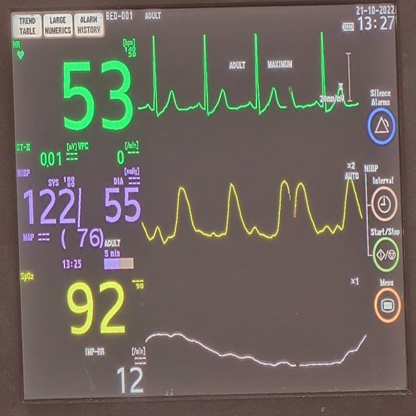

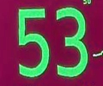

0
53





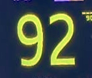

4
92





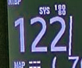

1
1221





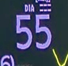

2
55





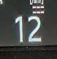

5
12





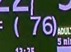

3
76



{'hr_label': '53', 'sbp_label': '1221', 'dbp_label': '55', 'map_label': '76', 'spo2_label': '92', 'rr_label': '12'}


"\n'hr_label': None, \n'sbp_label': None, \n'dbp_label': None, \n'map_label': None,\n'spo2_label': None,\n'rr_label': None\n"

In [ ]:
a = Image.open('/home/sharchit/Desktop/ml/cloud-physician/Nihon-Kohden-lifescope-A/charaklucknow_icu_mon--1_2022_10_21_11_15_1.jpeg')
a = a.resize((416, 416))
display(a)
print(getDigit_BPL_A(a))

'''
'hr_label': None, 
'sbp_label': None, 
'dbp_label': None, 
'map_label': None,
'spo2_label': None,
'rr_label': None
'''

In [ ]:
def inference(heart_rate_path, spo2_path, sbp_path, dbp_path, map_path, rr_path):
    ans = {"HR": "", "SPO2": "", "RR": "", "SBP": "", "DBP": "", "MAP": ""}
    # Heart rate part begins

    result = reader.readtext(np.array(heart_rate_path), allowlist='0123456789')
    try:
        accu = result[0][2]
        result1 = int(result[0][1])
        ans["HR"] = result1
    except:
        ans["HR"] = 0

    # spo2 part begins
    result = reader.readtext(np.array(spo2_path), allowlist='0123456789')
    try:
        accu = result[0][2]
        result1 = int(result[0][1])
        ans["SPO2"] = result1

    except:
        ans["SPO2"]  = 0

    #sbp
    result = reader.readtext(np.array(sbp_path), allowlist='0123456789')
    try:
        accu = result[0][2]
        result1 = int(result[0][1])
        ans["SBP"]  = result1

    except:
        ans["SBP"]  = 0
    #dbp
    result = reader.readtext(np.array(dbp_path), allowlist='0123456789')
    try:
        accu = result[0][2]
        result1 = int(result[0][1])
        ans["DBP"]  = result1
    except:
        ans["DBP"]  =0
    #rr
    result = reader.readtext(np.array(rr_path), allowlist='0123456789')
    try:
        accu = result[0][2]
        result1 = result[0][1]
        ans["RR"]  = int(result1)

    except:
        ans["RR"]  =0
    #map
    result = reader.readtext(np.array(map_path), allowlist='()0123456789')
    try:
        accu = result[0][2]
        result1 = result[0][1]
        result1 = result1.replace("(", "")
        result1 = result1.replace(")", "")
        ans["MAP"]  = int(result1)
    except:
        ans["MAP"]  = 0
    return ans
